In [3]:
import pandas as pd
import numpy as np
import os
import json
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from scipy import stats




In [2]:
PROMPT_VERSIONS = 3
QUESTION_INDICES = [0,3]
LLM_VERSION = "41-mini"  # Change this to the desired LLM name
REPETITIONS = 5


QUESTIONS = [
    "Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben",
    "Deutschland soll seine Verteidigungsausgaben erhöhen",
    "Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.",
    "Die Förderung von Windenergie soll beendet werden.",
    "Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.",
]

QUESTIONS_SHORT = [
    "Tempolimit",
    "Verteidigungsausgaben",
    "Wahlrecht ab 16",
    "Windenergie",
    "Mietpreisbremse",
]

In [4]:
# open dir ../configs
# Get the current working directory of the notebook
notebook_path = os.getcwd()

# Collect all answer DataFrames for each version and repetition
n_questions = len(QUESTIONS)
all_answers_versions = pd.DataFrame()
json_files_versions = [[] for _ in range(PROMPT_VERSIONS * n_questions)]

for question_index in QUESTION_INDICES:

    config_path = os.path.join(notebook_path, f"../config/question_{question_index}")
    print(config_path)
    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]
    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        config_file = os.path.join(subdir_path, "config_0.json")
        try:
            with open(config_file, "r") as file:
                config_data = json.load(file)
            config_df = pd.json_normalize(config_data)
            party_1 = config_df["persons"][0][0]["party"]
            party_2 = config_df["persons"][0][1]["party"]
            name_1 = config_df["persons"][0][0]["name"]
            name_2 = config_df["persons"][0][1]["name"]
        except Exception as e:
            print(f"Error reading {config_file}: {e}")
            continue
        for v in range(PROMPT_VERSIONS ):
            for repetition in range(REPETITIONS):
                json_file = os.path.join(
                    subdir_path, f"out_{LLM_VERSION}_v{v}_{repetition}.json"
                )
                if os.path.isfile(json_file):
                    json_files_versions[v].append(json_file)
                else:
                    continue
                try:
                    with open(json_file, "r") as file:
                        data = json.load(file)
                except Exception as e:
                    print(f"Error reading {json_file}: {e}")
                    continue
                columns = {}
                columns["question_index"] = question_index
                columns["party_1"] = party_1
                columns["party_2"] = party_2
                columns["repetition"] = repetition
                columns["version"] = v
                for q in data["survey_question"]:
                    name = q["chat_entry"]["entity"]["name"]
                    name = "agent_1" if name == name_1 else "agent_2"
                    iteration = q["iteration"]
                    col_name = f"{name}_T{iteration}"
                    columns[col_name] = q["chat_entry"]["answer"]
                answers_df = pd.DataFrame([columns])

                all_answers_versions = pd.concat([all_answers_versions, answers_df], ignore_index=True)


display(all_answers_versions)

print(f"length of all_answers_versions: {len(all_answers_versions)}")


/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_0
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_3


,question_index,party_1,party_2,repetition,version,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,0,0,4,3,5,3,6,3,6,3,6,3,6,3
1,0,CDU/CSU,AfD,1,0,4,3,5,3,6,3,6,3,5,3,6,3
2,0,CDU/CSU,AfD,2,0,4,3,6,3,5,3,5,3,6,3,5,3
3,0,CDU/CSU,AfD,3,0,4,3,5,3,5,3,6,3,6,4,5,4
4,0,CDU/CSU,AfD,4,0,4,3,5,5,5,6,5,6,5,6,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3,FDP,CDU/CSU,0,2,2,4,1,2,1,2,1,2,1,1,1,2
836,3,FDP,CDU/CSU,1,2,1,4,1,2,1,2,1,1,1,1,1,1
837,3,FDP,CDU/CSU,2,2,2,5,1,2,1,1,1,2,1,2,1,1
838,3,FDP,CDU/CSU,3,2,2,4,1,1,1,1,1,1,1,1,1,1


length of all_answers_versions: 840


In [ ]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df: pd.DataFrame) -> pd.DataFrame:
    t_row = ["party", "debate_with", "repetition"]
    formatted_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]
        version = int(row[1]["version"])
        repetition = int(row[1]["repetition"])
        question_index = int(row[1]["question_index"])

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        agent_1_data.insert(0, "repetition", repetition)
        agent_1_data.insert(0, "version", version)
        agent_1_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_1_data], ignore_index=True)


        if party_1 == party_2:
            # If both agents are the same, we only need one row
            continue


        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        agent_2_data.insert(0, "repetition", repetition)
        agent_2_data.insert(0, "version", prompt_version)
        agent_2_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_2_data], ignore_index=True)
    
    formatted_df = formatted_df.reset_index(drop=True)
    for col in formatted_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formatted_df[col] = formatted_df[col].apply(extract_number)

    

    return formatted_df


formatted_df = process_big_df(all_answers_versions)
display(formatted_df)

,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,4,5,6,6,6,6
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3
2,CDU/CSU,AfD,1,0.0,0.0,4,5,6,6,5,6
3,AfD,CDU/CSU,1,0.0,0.0,3,3,3,3,3,3
4,CDU/CSU,AfD,2,0.0,0.0,4,6,5,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...
1465,CDU/CSU,FDP,2,3.0,2.0,5,2,1,2,2,1
1466,FDP,CDU/CSU,3,3.0,2.0,2,1,1,1,1,1
1467,CDU/CSU,FDP,3,3.0,2.0,4,1,1,1,1,1
1468,FDP,CDU/CSU,4,3.0,2.0,2,1,1,1,1,1


In [34]:
formatted_df_non_abs = formatted_df.copy()
party_df_non_abs = formatted_df_non_abs.melt(
    id_vars=["party", "debate_with", "version", "question_index", "repetition"],
    var_name="time",
    value_name="answer",
)
party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
display(party_df_non_abs)



,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,4
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,4
3,AfD,CDU/CSU,0.0,0.0,1,T0,3
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2.0,3.0,2,T20,1
8816,FDP,CDU/CSU,2.0,3.0,3,T20,1
8817,CDU/CSU,FDP,2.0,3.0,3,T20,1
8818,FDP,CDU/CSU,2.0,3.0,4,T20,1


In [35]:
test = (
    party_df_non_abs['party'].astype(str)
    + "_"
    + party_df_non_abs["debate_with"].astype(str)
    + "_"
    + party_df_non_abs["repetition"].astype(str)
    + "_"
    + party_df_non_abs["version"].astype(str)
)

print(len(party_df_non_abs))
# expected length
# party 8
# debate_with 8
# repetition 5
# version 3
# questions 2
# time 6
expected_length = 7 * 7 * 5 * 3 * 2 * 6
print(f"Expected length: {expected_length}")

# print unique values and their counts
group_counts = test.value_counts().sort_values().to_dict()
print(f"Group counts: {group_counts}")

8820
Expected length: 8820
Group counts: {'CDU/CSU_AfD_0_0.0': 12, 'AfD_CDU/CSU_0_2.0': 12, 'CDU/CSU_AfD_1_0.0': 12, 'AfD_CDU/CSU_1_0.0': 12, 'CDU/CSU_AfD_2_0.0': 12, 'AfD_CDU/CSU_2_0.0': 12, 'CDU/CSU_AfD_3_0.0': 12, 'AfD_CDU/CSU_3_0.0': 12, 'CDU/CSU_AfD_4_0.0': 12, 'AfD_CDU/CSU_4_0.0': 12, 'CDU/CSU_AfD_0_1.0': 12, 'AfD_CDU/CSU_0_1.0': 12, 'CDU/CSU_AfD_1_1.0': 12, 'AfD_CDU/CSU_1_1.0': 12, 'CDU/CSU_AfD_2_1.0': 12, 'AfD_CDU/CSU_2_1.0': 12, 'CDU/CSU_AfD_3_1.0': 12, 'AfD_CDU/CSU_3_1.0': 12, 'CDU/CSU_AfD_4_1.0': 12, 'AfD_CDU/CSU_4_1.0': 12, 'AfD_Bündnis 90/Die Grünen_2_1.0': 12, 'CDU/CSU_AfD_0_2.0': 12, 'CDU/CSU_AfD_1_2.0': 12, 'AfD_Bündnis 90/Die Grünen_1_1.0': 12, 'AfD_CDU/CSU_1_2.0': 12, 'AfD_CDU/CSU_2_2.0': 12, 'CDU/CSU_AfD_3_2.0': 12, 'AfD_CDU/CSU_3_2.0': 12, 'CDU/CSU_AfD_4_2.0': 12, 'AfD_CDU/CSU_4_2.0': 12, 'Bündnis 90/Die Grünen_AfD_0_0.0': 12, 'AfD_Bündnis 90/Die Grünen_0_0.0': 12, 'Bündnis 90/Die Grünen_AfD_1_0.0': 12, 'AfD_Bündnis 90/Die Grünen_1_0.0': 12, 'Bündnis 90/Die Grünen_A

8820
Index(['party', 'debate_with', 'version', 'question_index', 'repetition',
       'time', 'answer'],
      dtype='object')


,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,4
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,4
3,AfD,CDU/CSU,0.0,0.0,1,T0,3
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2.0,3.0,2,T20,1
8816,FDP,CDU/CSU,2.0,3.0,3,T20,1
8817,CDU/CSU,FDP,2.0,3.0,3,T20,1
8818,FDP,CDU/CSU,2.0,3.0,4,T20,1


QUESION_INDICES: [0 3]   
Plotting question index 0


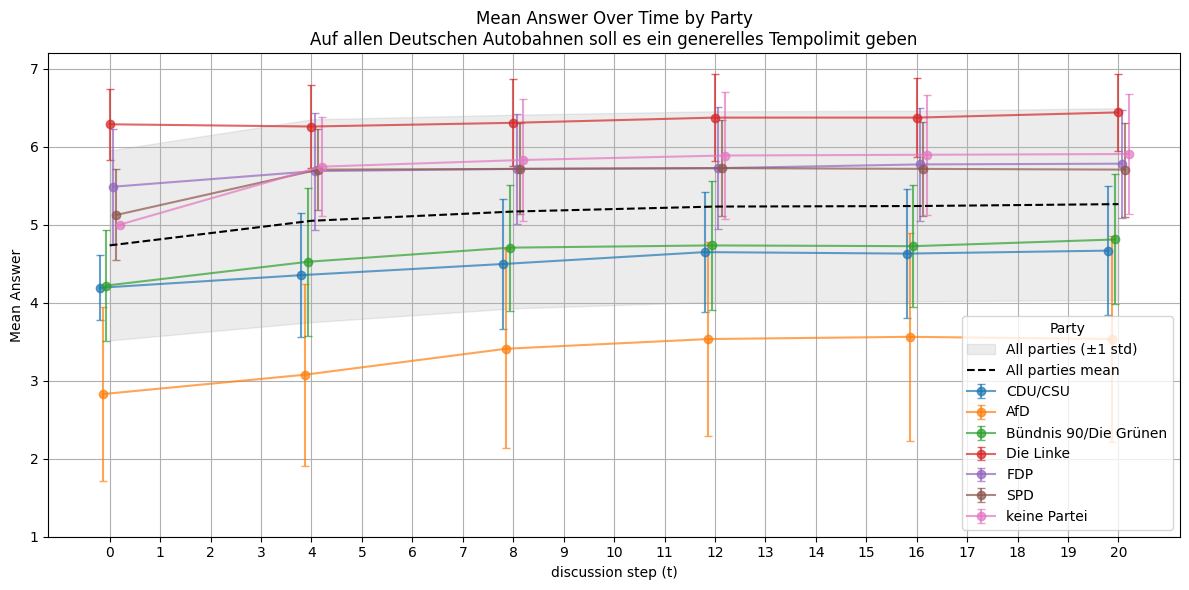

Plotting question index 3


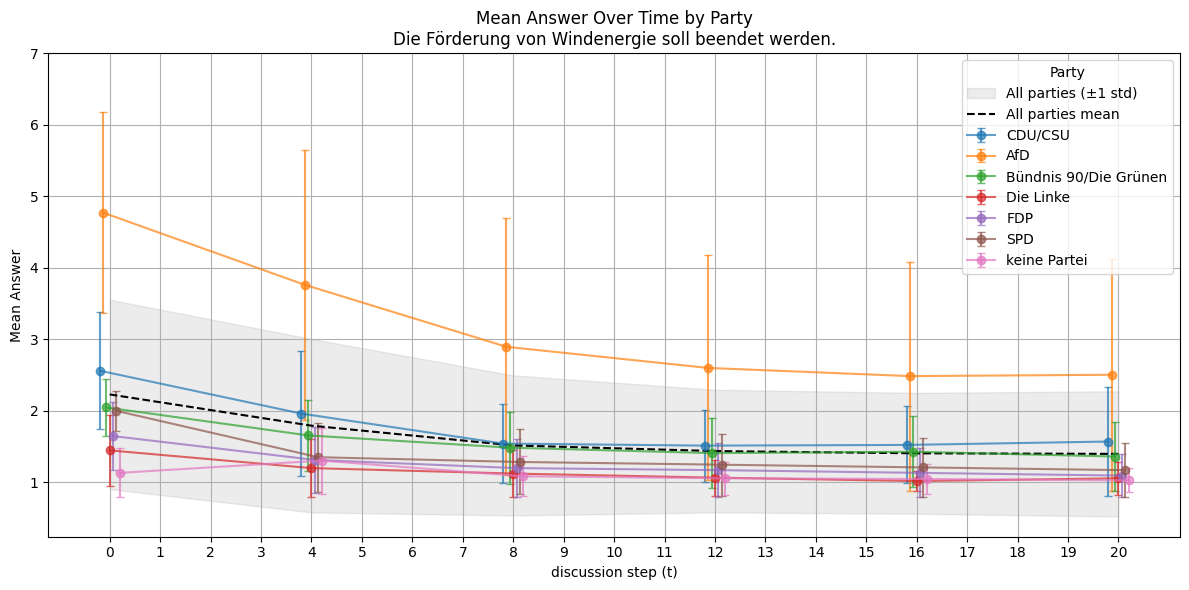

In [36]:
plot_df = party_df_non_abs.copy()


print(len(plot_df))
print(plot_df.columns)

display(plot_df)
plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

print(f"QUESION_INDICES: {plot_df["question_index"].unique()}   ")

for question in plot_df["question_index"].unique():
    print(f"Plotting question index {question}")
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, party in enumerate(parties):
        party_data = plot_df[
            (plot_df["party"] == party) & (plot_df["question_index"] == question)
        ]
        means = party_data.groupby("time")["answer"].mean()
        stds = party_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{party}",
            capsize=3,
            alpha=0.7,
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()
    plt.show()

Plotting for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben


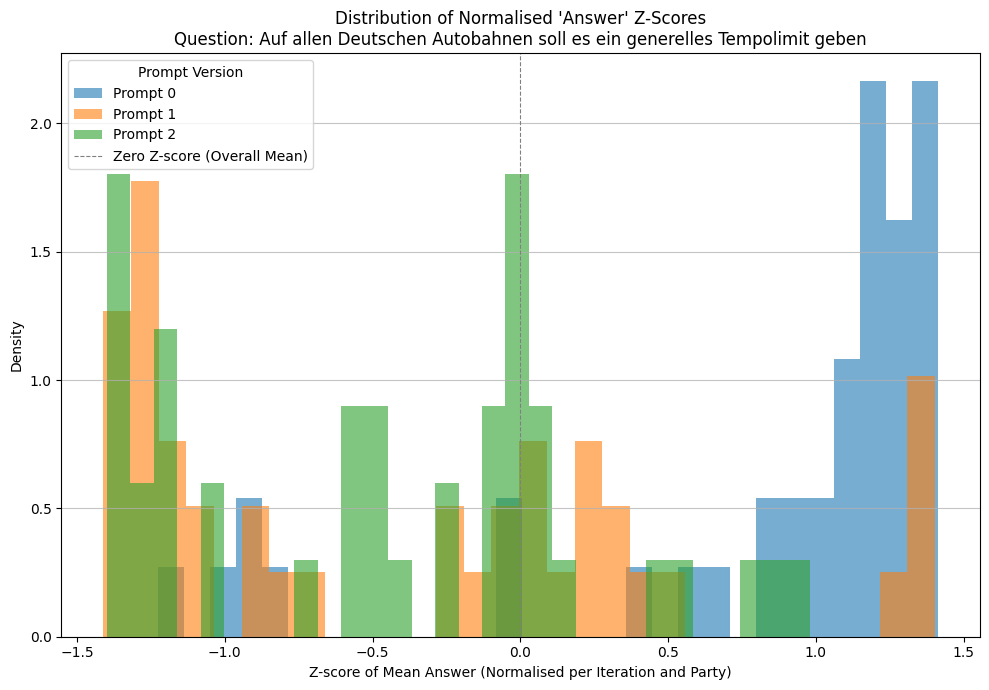

Plotting for question 3: Die Förderung von Windenergie soll beendet werden.


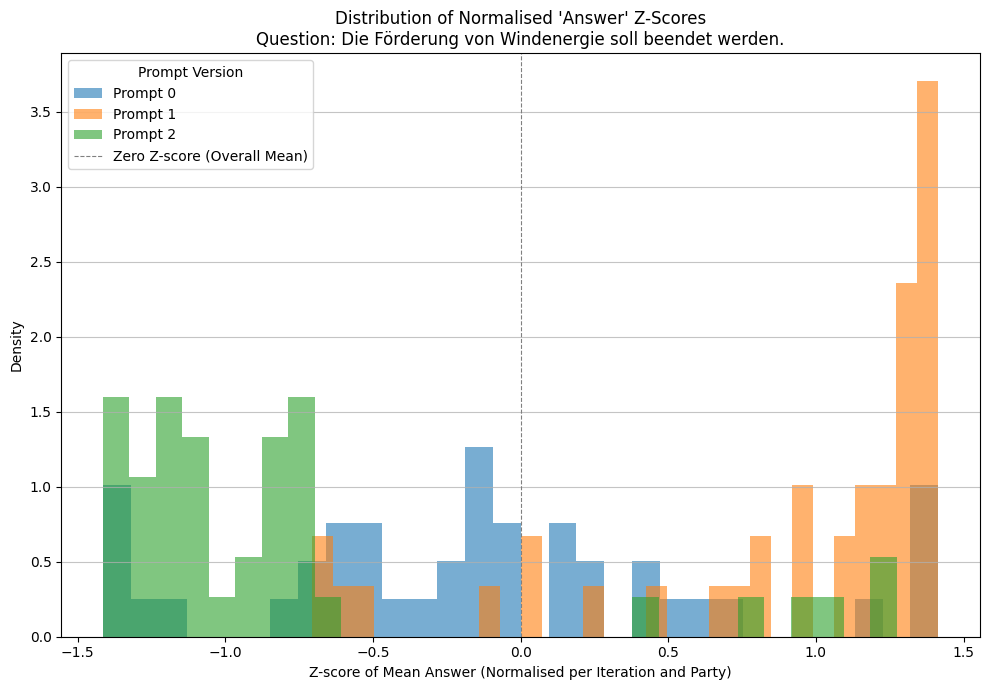

In [37]:
prompt_labels = {
    0: "Prompt 0",
    1: "Prompt 1",
    2: "Prompt 2"
}

for question in plot_df["question_index"].unique():
    print(f"Plotting for question {question}: {QUESTIONS[int(question)]}")

    # Aggregate means per repetition, party, version for this question
    aggregated_means = plot_df[plot_df["question_index"] == question].groupby(
        ["time", "party", "version"]
    )["answer"].mean().reset_index()
    aggregated_means.rename(columns={"answer": "mean_answer"}, inplace=True)

    # Normalise per time and party
    normalised_df = pd.DataFrame()
    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            iteration_data = aggregated_means[
                (aggregated_means["time"] == time)
                & (aggregated_means["party"] == party)
            ].copy()
            scaler = StandardScaler()
            iteration_data["z_score"] = scaler.fit_transform(iteration_data[["mean_answer"]])
            normalised_df = pd.concat([normalised_df, iteration_data])

    plt.figure(figsize=(10, 7))
    versions_sorted = sorted(normalised_df["version"].unique())
    for version_str in versions_sorted:
        prompt_v = int(version_str)
        version_data = normalised_df[normalised_df["version"] == version_str]
        plt.hist(
            version_data["z_score"],
            bins=30,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype='stepfilled'
        )
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Z-score (Overall Mean)')
    plt.title(f"Distribution of Normalised 'Answer' Z-Scores\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


```


For each question:
    Z0 = []
    Z1 = []
    Z2 = []

    For each Timestep:
        For each Party:
            data = Data(question, timestep, party)
            scaler = Scaler(data)

            mean_v0 = data(version = 0)
            mean_v1 = data(version = 1)
            mean_v2 = data(version = 2)

            Z0.append = scaler.apply(mean_0)
            Z1.append = scaler.apply(mean_1)
            Z2.append = scaler.apply(mean_2)


    Histogram(Z0,Z1,Z2)
```


    

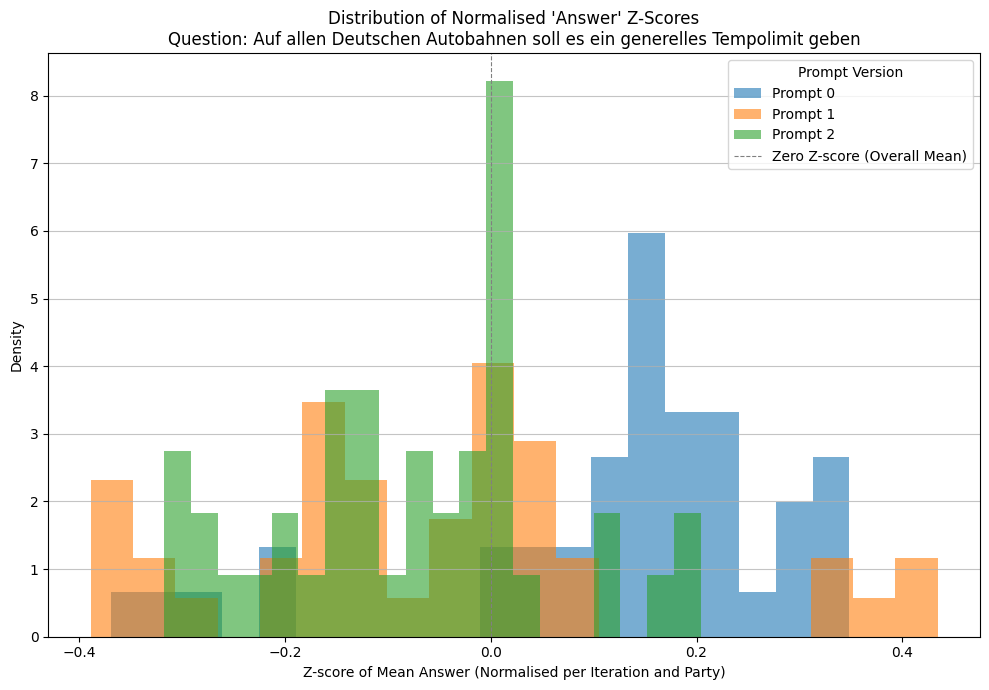

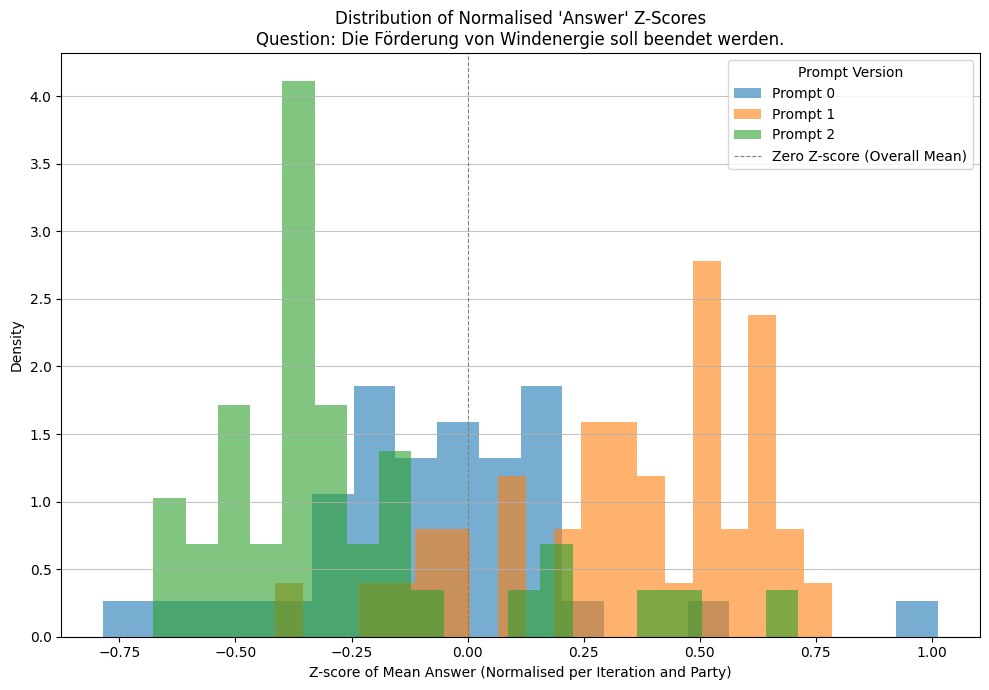

In [38]:
prompt_labels = {
    0: "Prompt 0",
    1: "Prompt 1",
    2: "Prompt 2"
}

for question in plot_df["question_index"].unique():
    normalised_df = {0: [], 1: [], 2: []}
    aggregated_means = plot_df[plot_df["question_index"] == question].copy()


    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            iteration_data = aggregated_means[
                 (aggregated_means["time"] == time)
                & (aggregated_means["party"] == party)
                
            ].copy()
            scaler = StandardScaler()
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))
            for prompt_v in range(3):
                mean = np.mean(
                    iteration_data[iteration_data["version"] == prompt_v]["answer"]
                )
                z_score = scaler.transform(np.array([[mean]]))[0][0]
                normalised_df[prompt_v].append(z_score)

    plt.figure(figsize=(10, 7))
    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        prompt_v = version_str
        version_data = normalised_df[prompt_v]
        plt.hist(
            version_data,
            bins=20,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype="stepfilled",
        )
    plt.axvline(
        0, color="grey", linestyle="--", linewidth=0.8, label="Zero Z-score (Overall Mean)"
    )
    plt.title(f"Distribution of Normalised 'Answer' Z-Scores\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()
    plt.show()


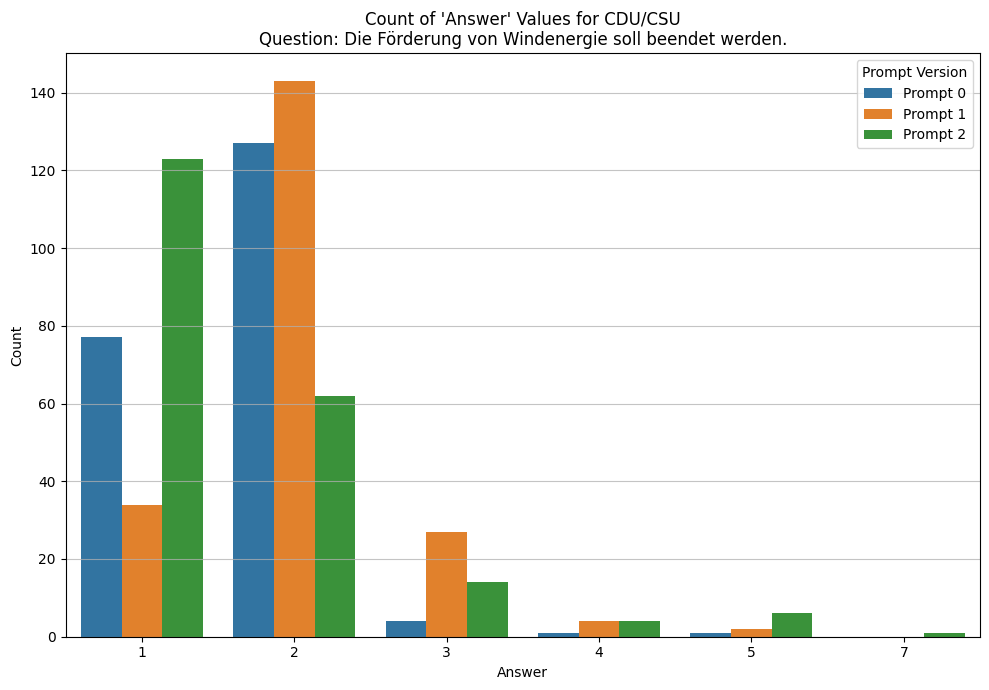

In [39]:
import seaborn as sns

# Only plot bar counts for q3 for party CDU/CSU, split by prompt version
pp = "CDU/CSU"
q3_cdu_df = plot_df[
    (plot_df["question_index"] == 3) & (plot_df["party"] == pp)
].copy()

q3_cdu_df['answer'] = q3_cdu_df['answer'].astype(int)
q3_cdu_df['prompt'] = q3_cdu_df['version'].astype(int)
q3_cdu_df['prompt'] = q3_cdu_df['prompt'].apply(lambda x: f"Prompt {x}")

plt.figure(figsize=(10, 7))
sns.countplot(
    data=q3_cdu_df,
    x="answer",
    hue="prompt",
    palette="tab10",
    dodge=True,
    hue_order=["Prompt 0", "Prompt 1", "Prompt 2"]
)
plt.title(f"Count of 'Answer' Values for {pp}\nQuestion: {QUESTIONS[3]}")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.legend(title="Prompt Version")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()


In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for question in plot_df["question_index"].unique():
    question_data = plot_df[plot_df["question_index"] == question]
    groups_answers = [group["answer"] for name, group in question_data.groupby("version")]

    stat, p = stats.kruskal(*groups_answers)

    k = len(groups_answers) 
    n_total = sum([len(g) for g in groups_answers]) 
    k = len(groups_answers) 

    epsilon_squared = (stat - k + 1) / (n_total - 1)

    print(f"Epsilon-squared: {epsilon_squared:.3f}")
    print(f"Kruskal-Wallis test for Question {question}: H-statistic = {stat:.3f}, p-value = {p:.3f}")

    
    if p < 0.05: 
        print(f"Significant result for Question {question}. Consider post-hoc tests and pairwise effect sizes.")

        # pairwise comparisons
        posthoc = pairwise_tukeyhsd(endog=question_data["answer"], groups=question_data["version"], alpha=0.05)
        print(posthoc)

        


Epsilon-squared: 0.003
Kruskal-Wallis test for Question 0: H-statistic = 16.647, p-value = 0.000
Significant result for Question 0. Consider post-hoc tests and pairwise effect sizes.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1252 0.0182 -0.2332 -0.0171   True
   0.0    2.0  -0.1585 0.0017 -0.2666 -0.0504   True
   1.0    2.0  -0.0333 0.7498 -0.1414  0.0747  False
----------------------------------------------------
Epsilon-squared: 0.043
Kruskal-Wallis test for Question 3: H-statistic = 193.522, p-value = 0.000
Significant result for Question 3. Consider post-hoc tests and pairwise effect sizes.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.3102    0.0  0.2185  0.4019   True
   0.0    2.0  -0.1082 0.0157 -0.1998 -0.0165   Tr

     party debate_with  version  question_index  repetition  time  answer
0  CDU/CSU         AfD      0.0               0           0     0       4
1      AfD     CDU/CSU      0.0               0           0     0       3
2  CDU/CSU         AfD      0.0               0           1     0       4
3      AfD     CDU/CSU      0.0               0           1     0       3
4  CDU/CSU         AfD      0.0               0           2     0       4
length of version_data for 0: 1470
length of version_data for 1: 1470
length of version_data for 2: 1470
length of version_data for 0: 2940
length of version_data for 1: 2940
length of version_data for 2: 2940


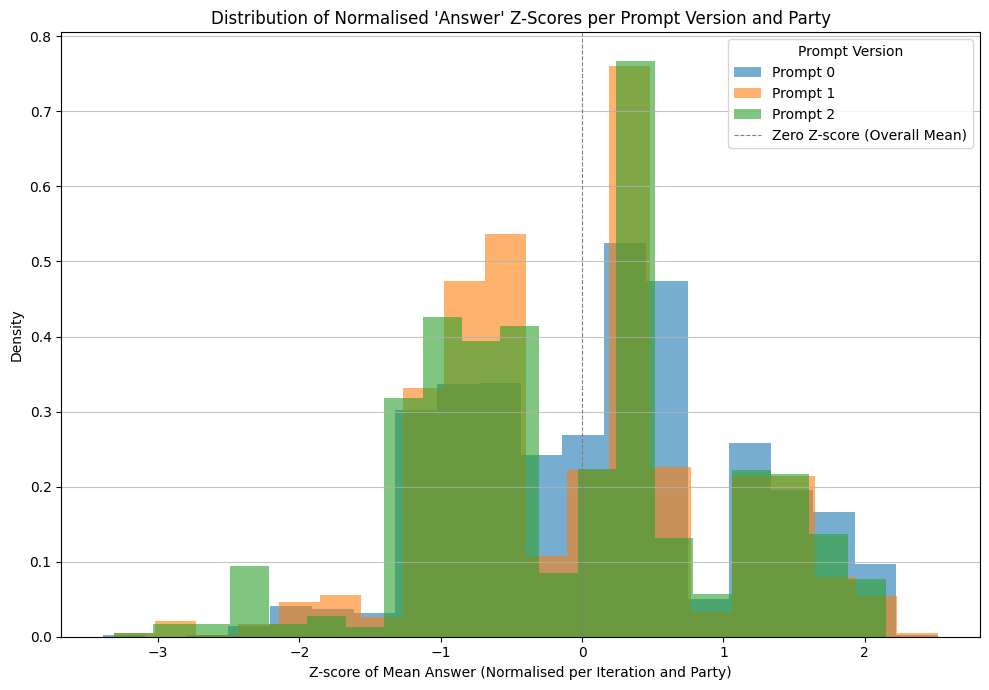

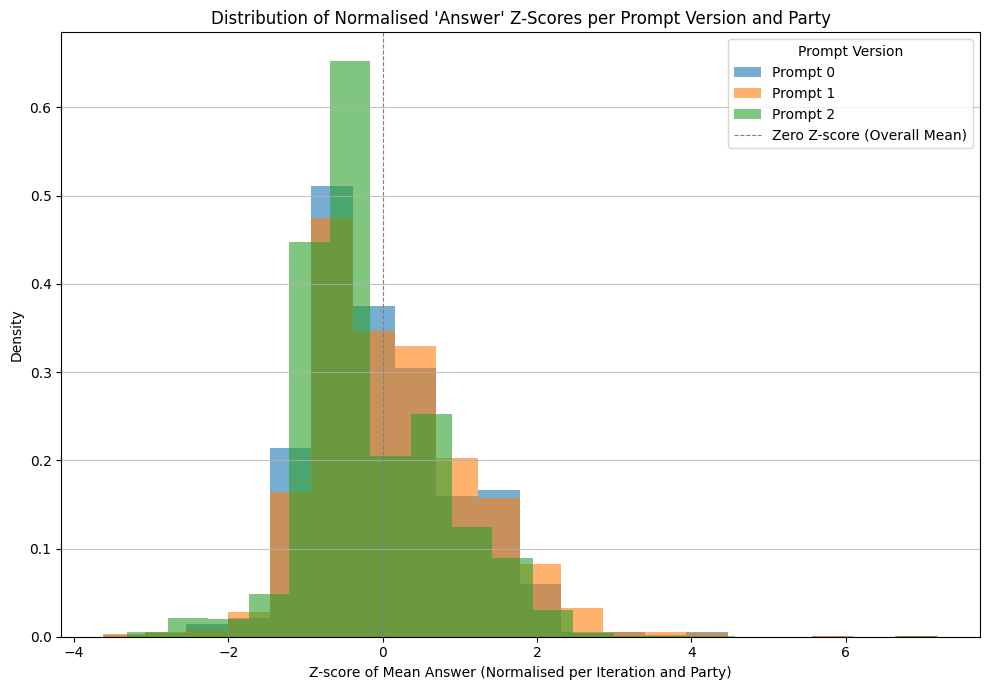

In [41]:
aggregated_means = plot_df.copy()

# Create an empty dictionary to store normalised data for each version
normalised_df = {0: [], 1: [], 2: []}


print(aggregated_means.head())

for  question in plot_df["question_index"].unique():

    for time in aggregated_means["time"].unique():
        for party in aggregated_means["party"].unique():
            # Filter data for the current repetition and party
            iteration_data = aggregated_means[
                (aggregated_means["question_index"] == question)
                & (aggregated_means["time"] == time)
                & (aggregated_means["party"] == party)
            ].copy()

            # Fit StandardScaler on the 'mean_answer' for this iteration
            scaler = StandardScaler()
            # Reshape to 2D array as StandardScaler expects this
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))

            for prompt_v in range(3):
                # Filter data for the current version
                data_for_version = iteration_data[
                    iteration_data["version"] == prompt_v
                ]
                

                z_scores: list = scaler.transform(data_for_version["answer"].values.reshape(-1, 1)).flatten().tolist()

                normalised_df[prompt_v].extend(z_scores)



    # plot data
    plt.figure(figsize=(10, 7))
    # Ensure versions are sorted for consistent plotting
    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        # Extract the numeric part of the version string (e.g., 'out_0' -> 0)
        prompt_v = version_str

        # Filter data for the current version
        version_data = normalised_df[prompt_v]
        print(f"length of version_data for {version_str}: {len(version_data)}")

        plt.hist(
            version_data,
            bins=20,  # You can adjust the number of bins
            alpha=0.6,  # Transparency to see overlaps
            label=prompt_labels[prompt_v],
            density=True,  # Normalise to form a probability density
            histtype="stepfilled",  # A nice style for multiple histograms
        )
    plt.axvline(
        0, color="grey", linestyle="--", linewidth=0.8, label="Zero Z-score (Overall Mean)"
    )  # Add a line at 0 for reference
    plt.title("Distribution of Normalised 'Answer' Z-Scores per Prompt Version and Party")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()

# calculating Anova at T20

In [42]:
# Perform ANOVA for each question
for question_index in QUESTION_INDICES:
    print(f"ANOVA for question {question_index}: {QUESTIONS[question_index]}")

    question_data = formatted_df_non_abs[
        formatted_df_non_abs["question_index"] == question_index
    ]

    if question_data.empty:
        print("No data available for this question.")
        continue

    # Fit OLS model
    model = ols(
        "T20 ~ C(version)*C(party) + C(debate_with)",
        data=question_data
    ).fit()

    # Get ANOVA table
    anova_table = anova_lm(model, typ=2)  # typ=2 is common for factorial designs
    print(anova_table)




ANOVA for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben
                         sum_sq     df           F         PR(>F)
C(version)             7.594558    2.0    5.941155   2.761861e-03
C(party)             609.959184    6.0  159.055201  1.253673e-127
C(debate_with)        23.082993    6.0    6.019206   3.730449e-06
C(version):C(party)   15.167347   12.0    1.977547   2.372729e-02
Residual             452.517007  708.0         NaN            NaN
ANOVA for question 3: Die Förderung von Windenergie soll beendet werden.
                         sum_sq     df          F        PR(>F)
C(version)            27.398639    2.0  31.534384  7.599963e-14
C(party)             173.455782    6.0  66.546141  1.459130e-65
C(debate_with)        16.255782    6.0   6.236515  2.139110e-06
C(version):C(party)   37.515646   12.0   7.196421  1.673502e-12
Residual             307.572789  708.0        NaN           NaN


In [43]:
party_df_non_abs

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,4
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,4
3,AfD,CDU/CSU,0.0,0.0,1,T0,3
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2.0,3.0,2,T20,1
8816,FDP,CDU/CSU,2.0,3.0,3,T20,1
8817,CDU/CSU,FDP,2.0,3.0,3,T20,1
8818,FDP,CDU/CSU,2.0,3.0,4,T20,1


In [44]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party


# Prepare the main dataframe for LMM once, outside the loop
lmm_data = party_df_non_abs.copy()
lmm_data['version'] = lmm_data['version'].astype('category')
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(
    lambda x: x / 4 if pd.notna(x) else np.nan
)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    ["keine Partei", "AfD", "Bündnis 90/Die Grünen", "CDU/CSU", "Die Linke", "FDP", "SPD"],
    ordered=False
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)


display(lmm_data)



for question_index in lmm_data["question_index"].unique():
    for prompt_version in lmm_data["version"].unique():
        print(f"Processing version: {prompt_version}")

        # Filter the data for the current version
        version_data = lmm_data[(lmm_data["version"] == prompt_version) & (lmm_data["question_index"] == question_index)].copy()

        # Define groups for this subset of data
        groups = (
            version_data["party"].astype(str)
            + "_"
            + version_data["debate_with"].astype(str)
            + "_"
            + version_data["repetition"].astype(str)
        )

        md = smf.mixedlm(
            "answer ~ C(party) * time",
            version_data,
            groups=groups,
        )
        mdf = md.fit()
        print(mdf.summary())

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,4
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,4
3,AfD,CDU/CSU,0.0,0.0,1,0.0,3
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2.0,3.0,2,5.0,1
8816,FDP,CDU/CSU,2.0,3.0,3,5.0,1
8817,CDU/CSU,FDP,2.0,3.0,3,5.0,1
8818,FDP,CDU/CSU,2.0,3.0,4,5.0,1


Processing version: 0.0
                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         answer    
No. Observations:           1470            Method:                     REML      
No. Groups:                 245             Scale:                      0.1903    
Min. group size:            6               Log-Likelihood:             -1217.0317
Max. group size:            6               Converged:                  Yes       
Mean group size:            6.0                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               5.242    0.123  42.766 0.000  5.002  5.482
C(party)[T.AfD]                        -2.174    0.173 -12.542 0.000 -2.514 -1.834
C(p

In [ ]:
from scipy.stats import norm # Correct import

########################### TEST ######################################
lmm_data = party_df_non_abs.copy()
lmm_data['version'] = lmm_data['version'].astype('category')
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(
    lambda x: x / 4 if pd.notna(x) else np.nan
)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    ["keine Partei", "AfD", "Bündnis 90/Die Grünen", "CDU/CSU", "Die Linke", "FDP", "SPD"],
    ordered=False
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)


display(lmm_data)



for question_index in lmm_data["question_index"].unique():

    # Filter the data for the current version
    version_data = lmm_data[(lmm_data["question_index"] == question_index)].copy()

    # # Define groups for this subset of data
    version_data['dummy_code'] = 1


    # Specify the fixed effects formula
    fixed_formula = 'answer ~ party + debate_with  + C(version)*time'

    # Specify the random effects and random slopes using vc_formula
    # '1' represents the random intercept, 'time' represents the random slope
    # The '0 + ' syntax ensures there is no redundant intercept
    vc = {'repetition': '0 + C(repetition)', 'repetition_time_slope': '0 + time:C(repetition)'}
    

    # Fit the model
    model = smf.mixedlm(
        fixed_formula,
        vc_formula=vc,
        groups=version_data['dummy_code'],  # Using a dummy code for grouping
        data=version_data
    )

    # Fitting can be computationally intensive, so it's good to use the recommended optimizer
    result = model.fit(method=['lbfgs'])


    # Extract parameters and the covariance matrix
    params = result.params
    cov = result.cov_params()

    # The reference prompt version is 'A' by default.
    # The coefficient for `time` represents the slope for prompt version 'A'.
    slope_A = params['time']
    se_A = np.sqrt(cov.loc['time', 'time'])
    z_A = slope_A / se_A
    p_A = 2 * (1 - norm.cdf(np.abs(z_A)))

    print("--- Simple Slope for Prompt Version 'A' ---")
    print(f"Slope: {slope_A:.4f}")
    print(f"Std. Error: {se_A:.4f}")
    print(f"Z-value: {z_A:.4f}")
    print(f"P-value: {p_A:.4f}")


    # The slope for prompt version 'B' is the sum of the main `time` coefficient
    # and the interaction term for `B`.
    slope_B = params['time'] + params['C(version)[T.1.0]:time']

    # To get the standard error, you need the covariance between `time` and the
    # interaction term, plus their variances.
    var_B = cov.loc['time', 'time'] + cov.loc['C(version)[T.1.0]:time', 'C(version)[T.1.0]:time'] + 2 * cov.loc['time', 'C(version)[T.1.0]:time']
    se_B = np.sqrt(var_B)
    z_B = slope_B / se_B
    p_B = 2 * (1 - norm.cdf(np.abs(z_B)))

    print("\n--- Simple Slope for Prompt Version 'B' ---")
    print(f"Slope: {slope_B:.4f}")
    print(f"Std. Error: {se_B:.4f}")
    print(f"Z-value: {z_B:.4f}")
    print(f"P-value: {p_B:.4f}")

    # The same logic applies to prompt version 'C'
    slope_C = params['time'] + params['C(version)[T.2.0]:time']
    var_C = cov.loc['time', 'time'] + cov.loc['C(version)[T.2.0]:time', 'C(version)[T.2.0]:time'] + 2 * cov.loc['time', 'C(version)[T.2.0]:time']
    se_C = np.sqrt(var_C)
    z_C = slope_C / se_C
    p_C = 2 * (1 - norm.cdf(np.abs(z_C)))

    print("\n--- Simple Slope for Prompt Version 'C' ---")
    print(f"Slope: {slope_C:.4f}")
    print(f"Std. Error: {se_C:.4f}")
    print(f"Z-value: {z_C:.4f}")
    print(f"P-value: {p_C:.4f}")





,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,4
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,4
3,AfD,CDU/CSU,0.0,0.0,1,0.0,3
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2.0,3.0,2,5.0,1
8816,FDP,CDU/CSU,2.0,3.0,3,5.0,1
8817,CDU/CSU,FDP,2.0,3.0,3,5.0,1
8818,FDP,CDU/CSU,2.0,3.0,4,5.0,1


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


--- Simple Slope for Prompt Version 'A' ---
Slope: 0.1012
Std. Error: 0.0121
Z-value: 8.3972
P-value: 0.0000

--- Simple Slope for Prompt Version 'B' ---
Slope: 0.1075
Std. Error: 0.0121
Z-value: 8.9197
P-value: 0.0000

--- Simple Slope for Prompt Version 'C' ---
Slope: 0.0722
Std. Error: 0.0121
Z-value: 5.9884
P-value: 0.0000
--- Simple Slope for Prompt Version 'A' ---
Slope: -0.1446
Std. Error: 0.0126
Z-value: -11.4912
P-value: 0.0000

--- Simple Slope for Prompt Version 'B' ---
Slope: -0.1280
Std. Error: 0.0126
Z-value: -10.1753
P-value: 0.0000

--- Simple Slope for Prompt Version 'C' ---
Slope: -0.1897
Std. Error: 0.0126
Z-value: -15.0775
P-value: 0.0000


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [103]:
from scipy.stats import norm  # Correct import

########################### TEST ######################################
lmm_data = party_df_non_abs.copy()
lmm_data["version"] = lmm_data["version"].astype("category")
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(lambda x: x / 4 if pd.notna(x) else np.nan)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    [
        "keine Partei",
        "AfD",
        "Bündnis 90/Die Grünen",
        "CDU/CSU",
        "Die Linke",
        "FDP",
        "SPD",
    ],
    ordered=False,
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)


# Filter the data for the current version
version_data = lmm_data.copy()

# Specify the fixed effects formula
fixed_formula = "answer ~ party + debate_with + C(version) * C(question_index) * time"

# Fit the model using the 'groups' argument for repetitions and 're_formula' for random effects.
# This is a more standard way to specify random intercepts and slopes for each repetition.
model = smf.mixedlm(
    fixed_formula,
    data=version_data,
    groups=version_data["repetition"],
    re_formula="~ 1 + time",  # Random intercept (1) and random slope for time
)


# Fitting can be computationally intensive, so it's good to use the recommended optimizer
result = model.fit(method=["lbfgs"])

print(result.summary())


# Assuming 'version' is your prompt_version and has levels 0, 1, 2
# Assuming 'question_ID' has levels 0, 1
prompt_versions = [0.0, 1.0, 2.0]
question_ids = [0.0, 3.0]

# Extract parameters and the covariance matrix
params = result.params
cov = result.cov_params()

print("\n--- Post-Hoc Simple Slopes Analysis ---")




for prompt in prompt_versions:
    for question in question_ids:
        # Determine the coefficient names based on the prompt and question
        if prompt == 0.0:
            prompt_term = "time"
            
            if question == 0.0:
                # Reference for both: main effect of time
                slope_coeff = params[prompt_term]
                
                var = cov.loc[prompt_term, prompt_term]
            else:
                # Reference prompt, but with a different question ID
                question_term = f"C(question_index)[T.{question}]:time"
                slope_coeff = params[prompt_term] + params[question_term]
                
                var = (
                    cov.loc[prompt_term, prompt_term]
                    + cov.loc[question_term, question_term]
                    + 2 * cov.loc[prompt_term, question_term]
                )
        else:
            # Different prompt version from reference
            prompt_term_inter = f"C(version)[T.{prompt}]:time"
            
            if question == 0.0:
                # Different prompt, but with the reference question ID
                slope_coeff = params["time"] + params[prompt_term_inter]
                
                var = (
                    cov.loc["time", "time"]
                    + cov.loc[prompt_term_inter, prompt_term_inter]
                    + 2 * cov.loc["time", prompt_term_inter]
                )
            else:
                # Different prompt and different question ID
                question_term = f"C(question_index)[T.{question}]:time"
                prompt_question_time_inter = f"C(version)[T.{prompt}]:C(question_index)[T.{question}]:time"
                
                slope_coeff = (
                    params["time"]
                    + params[prompt_term_inter]
                    + params[question_term]
                    + params[prompt_question_time_inter]
                )
                
                # Manual calculation of variance for a three-way interaction
                var = (
                    cov.loc["time", "time"]
                    + cov.loc[prompt_term_inter, prompt_term_inter]
                    + cov.loc[question_term, question_term]
                    + cov.loc[prompt_question_time_inter, prompt_question_time_inter]
                    + 2 * cov.loc["time", prompt_term_inter]
                    + 2 * cov.loc["time", question_term]
                    + 2 * cov.loc["time", prompt_question_time_inter]
                    + 2 * cov.loc[prompt_term_inter, question_term]
                    + 2 * cov.loc[prompt_term_inter, prompt_question_time_inter]
                    + 2 * cov.loc[question_term, prompt_question_time_inter]
                )

        se = np.sqrt(var)
        z_value = slope_coeff / se
        p_value = 2 * (1 - norm.cdf(np.abs(z_value)))

        print(
            f"\n--- Simple Slope for Prompt: {prompt}, Question: {question} ---"
        )
        print(f"Slope: {slope_coeff:.4f}")
        print(f"Std. Error: {se:.4f}")
        print(f"Z-value: {z_value:.4f}")
        print(f"P-value: {p_value:.4f}")

                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            answer     
No. Observations:             8820               Method:                        REML       
No. Groups:                   5                  Scale:                         1.2502     
Min. group size:              1764               Log-Likelihood:                -13551.4445
Max. group size:              1764               Converged:                     No         
Mean group size:              1764.0                                                       
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                        5.005    0.066  75.669 0.000  4.876  5.135
party[T.AfD]   

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 10.693468
  warnings.warn(msg, ConvergenceWarning)
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# First Effect Model of Prompt sensitivity

In [45]:

for question_index in lmm_data["question_index"].unique():
    print(f"Processing question index: {question_index}")

    # Filter the data for the current question index
    question_data: pd.DataFrame = lmm_data[lmm_data["question_index"] == question_index].copy()
    question_data = question_data.reset_index(drop=True)


    # Define groups for this subset of data
    groups = (
        question_data["party"].astype(str)
        + "_"
        + question_data["debate_with"].astype(str)
        + "_"
        + question_data["repetition"].astype(str)
        + "_"
        + question_data["version"].astype(str)
    )

    # Full model: includes version
    full_model = smf.mixedlm(
        "answer ~ time + party + version",
        question_data,
        groups=groups
    ).fit()  
    print(full_model.summary())


Processing question index: 0.0
                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       answer    
No. Observations:       4410          Method:                   REML      
No. Groups:             735           Scale:                    0.2054    
Min. group size:        6             Log-Likelihood:           -3749.5522
Max. group size:        6             Converged:                Yes       
Mean group size:        6.0                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       5.570    0.077  72.471 0.000  5.419  5.721
party[T.AfD]                   -2.386    0.095 -25.101 0.000 -2.572 -2.199
party[T.Bündnis 90/Die Grünen] -1.090    0.095 -11.473 0.000 -1.277 -0.904
party[T.CDU/C

In [46]:
########### Likelihood-ratio test #########
for question_index in lmm_data["question_index"].unique():
    print(f"Processing question index: {question_index}")

    # Filter the data for the current question index
    question_data: pd.DataFrame = lmm_data[
        lmm_data["question_index"] == question_index
    ].copy()
    question_data = question_data.reset_index(drop=True)

    # Define groups for this subset of data
    groups = (
        question_data["party"].astype(str)
        + "_"
        + question_data["debate_with"].astype(str)
        + "_"
        + question_data["repetition"].astype(str)
        + "_"
        + question_data["version"].astype(str)
    )

    # Full model: includes version
    full_model = smf.mixedlm(
        "answer ~ time + party + version", question_data, groups=groups
    ).fit()
    # Reduced model: drop party
    no_party_model = smf.mixedlm(
        "answer ~ time + C(version)", question_data, groups=groups
    ).fit(reml=False)

    # Reduced model: drop version
    no_version_model = smf.mixedlm(
        "answer ~ time + C(party)", question_data, groups=groups
    ).fit(reml=False)
    # calculate Likelyhood ratio
    # LRT for party
    lr_stat_party = 2 * (full_model.llf - no_party_model.llf)
    df_diff_party = full_model.df_modelwc - no_party_model.df_modelwc
    p_value_party = stats.chi2.sf(lr_stat_party, df_diff_party)

    # LRT for version
    lr_stat_version = 2 * (full_model.llf - no_version_model.llf)
    df_diff_version = full_model.df_modelwc - no_version_model.df_modelwc
    p_value_version = stats.chi2.sf(lr_stat_version, df_diff_version)

    print(f"\nLRT for PARTY (does removing party worsen fit?):")
    print(f"  LRT statistic: {lr_stat_party:.2f}, df diff: {df_diff_party}, p-value: {p_value_party:.4f}")

    print(f"LRT for VERSION (does removing version worsen fit?):")
    print(f"  LRT statistic: {lr_stat_version:.2f}, df diff: {df_diff_version}, p-value: {p_value_version:.4f}")

    if lr_stat_party > lr_stat_version:
        print("=> PARTY has a bigger effect on the model fit than VERSION\n")
    elif lr_stat_version > lr_stat_party:
        print("=> VERSION has a bigger effect on the model fit than PARTY\n")
    else:
        print("=> PARTY and VERSION have similar effects on the model fit\n")

    

Processing question index: 0.0

LRT for PARTY (does removing party worsen fit?):
  LRT statistic: 743.68, df diff: 6, p-value: 0.0000
LRT for VERSION (does removing version worsen fit?):
  LRT statistic: -34.65, df diff: 2, p-value: 1.0000
=> PARTY has a bigger effect on the model fit than VERSION

Processing question index: 3.0

LRT for PARTY (does removing party worsen fit?):
  LRT statistic: 594.62, df diff: 6, p-value: 0.0000
LRT for VERSION (does removing version worsen fit?):
  LRT statistic: 24.25, df diff: 2, p-value: 0.0000
=> PARTY has a bigger effect on the model fit than VERSION



In [47]:
#################### TEST ####################  
for question_index in lmm_data["question_index"].unique():
    print(f"Processing question index: {question_index}")

    # Filter the data for the current question index
    question_data: pd.DataFrame = lmm_data[lmm_data["question_index"] == question_index].copy()
    question_data = question_data.reset_index(drop=True)


    # Define groups for this subset of data
    question_data["group"] = "dummy_group"

    vc = {
        "party": "0 + C(party)",
        "debate_with": "0 + C(debate_with)",
        "repetition": "0 + C(repetition)",
        "version": "0 + C(version)"
    }

    full_model = smf.mixedlm(
        "answer ~ time + party + version",
        question_data,
        groups=question_data["group"],
        vc_formula=vc
    ).fit()  
    print(full_model.summary())


Processing question index: 0.0


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        answer    
No. Observations:        4410           Method:                    REML      
No. Groups:              1              Scale:                     0.6217    
Min. group size:         4410           Log-Likelihood:            -5245.2325
Max. group size:         4410           Converged:                 Yes       
Mean group size:         4410.0                                              
-----------------------------------------------------------------------------
                               Coef.    Std.Err.     z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                       5.570        1.121  4.968 0.000  3.373  7.767
party[T.AfD]                   -2.386        1.116 -2.138 0.033 -4.573 -0.198
party[T.Bündnis 90/Die Grünen] -1.090        1.116 -0.977 0.329 -3.278  1.097
party[

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        answer    
No. Observations:         4410           Method:                    REML      
No. Groups:               1              Scale:                     0.5805    
Min. group size:          4410           Log-Likelihood:            -5094.8307
Max. group size:          4410           Converged:                 Yes       
Mean group size:          4410.0                                              
------------------------------------------------------------------------------
                               Coef.    Std.Err.      z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                       1.428        1.082   1.319 0.187 -0.693  3.548
party[T.AfD]                    2.060        1.078   1.911 0.056 -0.053  4.174
party[T.Bündnis 90/Die Grünen]  0.456        1.078   0.422 0.673 -1.658  

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [48]:


groups = (
    lmm_data["party"].astype(str)
    + "_"
    + lmm_data["debate_with"].astype(str)
    + "_"
    + lmm_data["repetition"].astype(str)
    + "_"
    + lmm_data["version"].astype(str)
)


# Full model: includes version
full_model = smf.mixedlm(
    "answer ~ time * question_index * party * version",
    lmm_data,
    groups=groups
).fit(reml=False)  # Use ML for LRT

print(full_model.summary())


# Reduced model: drop 'version' completely
reduced_model = smf.mixedlm(
    "answer ~ time * question_index * party",
    lmm_data,
    groups=groups
).fit(reml=False)

# LRT statistic
lr_stat = 2 * (full_model.llf - reduced_model.llf)

# Degrees of freedom = difference in number of parameters
df_diff = full_model.df_modelwc - reduced_model.df_modelwc

# p-value
p_value = stats.chi2.sf(lr_stat, df_diff)

print(f"LRT statistic: {lr_stat:.2f}")
print(f"df difference: {df_diff}")
print(f"p-value: {p_value:.4f}")



                                       Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     answer    
No. Observations:                     8820                        Method:                                 ML        
No. Groups:                           735                         Scale:                                  0.4933    
Min. group size:                      12                          Log-Likelihood:                         -9791.4783
Max. group size:                      12                          Converged:                              Yes       
Mean group size:                      12.0                                                                          
--------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.    z    P>|z| [

# Distance from Initial Opinion 
In the following I'll be answering RQ2: "Does discussion cause agents' opinions to significantly shift from their starting points and converge towards more uniform stances?" by calculting the distance from the original opinion

In [49]:
lmm_data

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,4
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,4
3,AfD,CDU/CSU,0.0,0.0,1,0.0,3
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2.0,3.0,2,5.0,1
8816,FDP,CDU/CSU,2.0,3.0,3,5.0,1
8817,CDU/CSU,FDP,2.0,3.0,3,5.0,1
8818,FDP,CDU/CSU,2.0,3.0,4,5.0,1


In [50]:
bla = formatted_df.copy()

# remove columns with missing values
bla = bla.dropna(axis=1, how="any")

# Calculate distance from initial opinion for each timepoint
for t in ["T0", "T4", "T8", "T12", "T16", "T20"]:
    bla[f"d{t[1:]}"] = abs(bla[t] - bla["T0"])

# Optionally, also include d0 (which is always zero)
#bla["d0"] = 0
display(bla)


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20,d0,d4,d8,d12,d16,d20
0,CDU/CSU,AfD,0,0.0,0.0,4,5,6,6,6,6,0,1,2,2,2,2
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3,0,0,0,0,0,0
2,CDU/CSU,AfD,1,0.0,0.0,4,5,6,6,5,6,0,1,2,2,1,2
3,AfD,CDU/CSU,1,0.0,0.0,3,3,3,3,3,3,0,0,0,0,0,0
4,CDU/CSU,AfD,2,0.0,0.0,4,6,5,5,6,5,0,2,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,CDU/CSU,FDP,2,3.0,2.0,5,2,1,2,2,1,0,3,4,3,3,4
1466,FDP,CDU/CSU,3,3.0,2.0,2,1,1,1,1,1,0,1,1,1,1,1
1467,CDU/CSU,FDP,3,3.0,2.0,4,1,1,1,1,1,0,3,3,3,3,3
1468,FDP,CDU/CSU,4,3.0,2.0,2,1,1,1,1,1,0,1,1,1,1,1


Plotting for question index 0.0 and version 0.0
Offset for version 0.0 and question index 0.0:
Offset index: 0
-0.2
Plotting for question index 3.0 and version 0.0
Offset for version 0.0 and question index 3.0:
Offset index: 1
-0.12000000000000001
Plotting for question index 0.0 and version 1.0
Offset for version 1.0 and question index 0.0:
Offset index: 2
-0.04000000000000001
Plotting for question index 3.0 and version 1.0
Offset for version 1.0 and question index 3.0:
Offset index: 3
0.03999999999999998
Plotting for question index 0.0 and version 2.0
Offset for version 2.0 and question index 0.0:
Offset index: 4
0.12
Plotting for question index 3.0 and version 2.0
Offset for version 2.0 and question index 3.0:
Offset index: 5
0.2


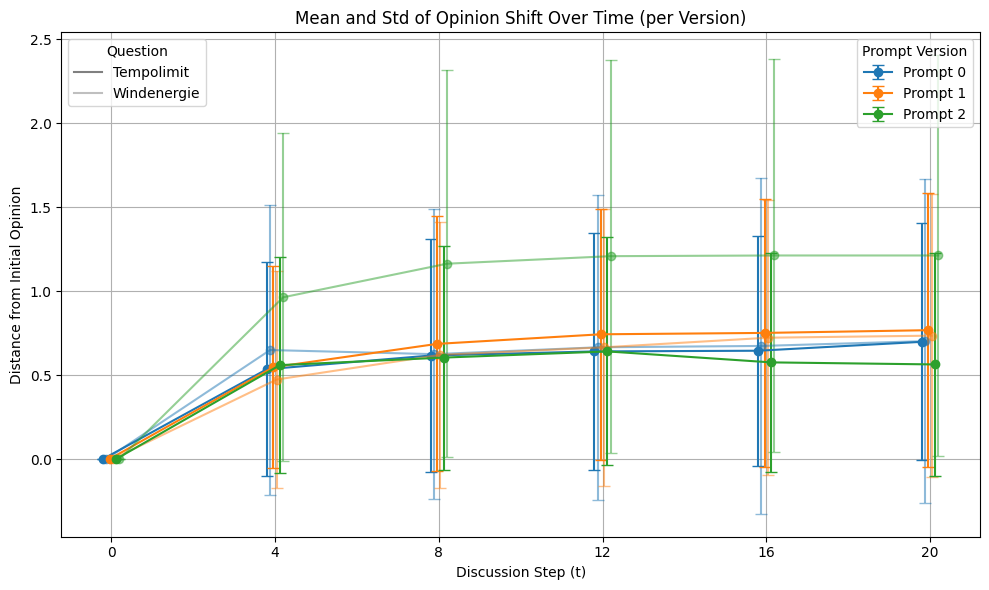

In [51]:
timepoints = ["d0", "d4", "d8", "d12", "d16", "d20"]
prompt_versions  = bla["version"].unique()
offsets = np.linspace(-0.2, 0.2, len(prompt_versions) * len(QUESTION_INDICES))  # Offset for each version and question index

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
opaqueness = [1, 0.5]



# ...existing code...
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []

for i, version in enumerate(prompt_versions):
    question_counter = 0
    for question_index in bla["question_index"].unique():
        print(f"Plotting for question index {question_index} and version {version}")
        version_data = bla[(bla["version"] == version) & (bla["question_index"] == question_index)]
        means = [version_data[tp].mean() for tp in timepoints]
        stds = [version_data[tp].std() for tp in timepoints]

        offset_i = i * len(QUESTION_INDICES) + question_counter
        print(f"Offset for version {version} and question index {question_index}:")
        print(f"Offset index: {offset_i}")
        print(offsets[int(offset_i)])

        x_vals = (
            np.array([int(tp[1:]) if tp != "d0" else 0 for tp in timepoints]) + offsets[int(offset_i)]
        )
        line = ax.errorbar(
            x_vals, means, yerr=stds, marker="o", capsize=4,
            label=f"Prompt {i}", color=colors[i], alpha=opaqueness[question_counter]
        )
        if question_counter == 0:
            prompt_handles.append(line)
        if i == 0:
            # Dummy lines for question legend
            dummy, = ax.plot([], [], color="gray", alpha=opaqueness[question_counter], label=f"Question {question_index}")
            question_handles.append(dummy)
        question_counter += 1

plt.xticks([0,  4, 8, 12, 16, 20])
plt.xlabel("Discussion Step (t)")
plt.ylabel("Distance from Initial Opinion")
plt.title("Mean and Std of Opinion Shift Over Time (per Version)")
plt.grid(True)

# First legend: Prompt Version (color)
legend1 = ax.legend(prompt_handles, [f"Prompt {i}" for i in range(len(prompt_versions))], title="Prompt Version", loc="upper right")
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(question_handles, [QUESTIONS_SHORT[int(q)] for q in bla["question_index"].unique()], title="Question", loc="upper left")

plt.tight_layout()
plt.show()
# ...existing code...

In [52]:
# flatten the data so instead of having d0, d4, d8, d12, d16, d20 as columns, we have a single column for distance and a column for time
xx = []
for version_label, df in enumerate(bla.groupby("version")):
    version_df = df[1]
    version_df = version_df.melt(
        id_vars=["party", "debate_with", "repetition", "version", "question_index"],
        value_vars=[f"d{t[1:]}" for t in timepoints],
        var_name="time",
        value_name="distance"
    )
    version_df["time"] = version_df["time"].str.replace("d", "").astype(int)
    version_df["version"] = version_label
    xx.append(version_df)
# Concatenate all versions into a single DataFrame

formatted_df_distance = pd.concat(xx, ignore_index=True)

formatted_df_distance

,party,debate_with,repetition,version,question_index,time,distance
0,CDU/CSU,AfD,0,0,0.0,0,0
1,AfD,CDU/CSU,0,0,0.0,0,0
2,CDU/CSU,AfD,1,0,0.0,0,0
3,AfD,CDU/CSU,1,0,0.0,0,0
4,CDU/CSU,AfD,2,0,0.0,0,0
...,...,...,...,...,...,...,...
8815,CDU/CSU,FDP,2,2,3.0,20,4
8816,FDP,CDU/CSU,3,2,3.0,20,1
8817,CDU/CSU,FDP,3,2,3.0,20,3
8818,FDP,CDU/CSU,4,2,3.0,20,1


In [53]:
formatted_df_distance["party"] = formatted_df_distance["party"].astype("category")
formatted_df_distance["party"] = formatted_df_distance["party"].cat.reorder_categories(
    [
        "keine Partei",
        "AfD",
        "Bündnis 90/Die Grünen",
        "CDU/CSU",
        "Die Linke",
        "FDP",
        "SPD",
    ],
    ordered=False,
)
formatted_df_distance["version"] = formatted_df_distance["version"].astype("category")


formatted_df_distance = formatted_df_distance[
    formatted_df_distance["time"] != 0
]  # Remove d0, as it is always zero

# mixed effects model for distance from initial opinion
groups = (
    formatted_df_distance["party"].astype(str)
    + "_"
    + formatted_df_distance["debate_with"].astype(str)
    + "_"
    + formatted_df_distance["repetition"].astype(str)
    + "_"
    + formatted_df_distance["version"].astype(str)
    + "_"
    + formatted_df_distance["question_index"].astype(str)
)
md = smf.mixedlm(
    "distance ~ time  + C(party) + time * C(version)",
    formatted_df_distance,
    groups=groups,
)
mdf = md.fit()
print(mdf.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       distance  
No. Observations:         7350          Method:                   REML      
No. Groups:               1470          Scale:                    0.1602    
Min. group size:          5             Log-Likelihood:           -5732.7232
Max. group size:          5             Converged:                Yes       
Mean group size:          5.0                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.394    0.057  6.867 0.000  0.282  0.506
C(party)[T.AfD]                    0.923    0.068 13.516 0.000  0.789  1.057
C(party)[T.Bündnis 90/Die Grünen]  0.130    0.068  1.897 0.058 -0.004  0.263
C(party)[T.CDU/CSU]

In [54]:

for question_index in formatted_df_distance["question_index"].unique():
    if question_index != 3.0:
        continue
    question_data = formatted_df_distance[formatted_df_distance["question_index"] == question_index].copy()



    # ensure that time = 0 is not included in the model (assert incase it is)
    assert (question_data["time"] != 0).all(), "Time = 0 should not be included in the model."

    # Define groups for this subset of data
    groups = (
        question_data["party"].astype(str)
        + "_"
        + question_data["debate_with"].astype(str)
        + "_"
        + question_data["repetition"].astype(str)
    )

    mdf = smf.mixedlm(
        "distance ~ time + C(party) + C(version) ",
        question_data,
        groups=groups,
    ).fit()
    

    no_party_model = smf.mixedlm(
        "distance ~ time + C(version)", question_data, groups=groups
    ).fit(reml=False)
    

    no_version_model = smf.mixedlm(
        "distance ~ time + C(party)", question_data, groups=groups
    ).fit(reml=False)


    # calculate Likelyhood ratio
    # LRT for party
    lr_stat_party = 2 * (mdf.llf - no_party_model.llf)
    df_diff_party = mdf.df_modelwc - no_party_model.df_modelwc
    p_value_party = stats.chi2.sf(lr_stat_party, df_diff_party)
    # LRT for version
    lr_stat_version = 2 * (mdf.llf - no_version_model.llf)
    df_diff_version = mdf.df_modelwc - no_version_model.df_modelwc
    p_value_version = stats.chi2.sf(lr_stat_version, df_diff_version)   

    print(f"\nLRT for PARTY (does removing party worsen fit?):")
    print(f"  LRT statistic: {lr_stat_party:.2f}, df diff: {df_diff_party}, p-value: {p_value_party:.4f}")

    print(f"\nLRT for VERSION (does removing version worsen fit?):")
    print(f"  LRT statistic: {lr_stat_version:.2f}, df diff: {df_diff_version}, p-value: {p_value_version:.4f}")
    if lr_stat_party > lr_stat_version:
        print("=> PARTY has a bigger effect on the model fit than VERSION\n")
    elif lr_stat_version > lr_stat_party:
        print("=> VERSION has a bigger effect on the model fit than PARTY\n")
    else:
        print("=> PARTY and VERSION have similar effects on the model fit\n")


LRT for PARTY (does removing party worsen fit?):
  LRT statistic: 199.85, df diff: 6, p-value: 0.0000

LRT for VERSION (does removing version worsen fit?):
  LRT statistic: 417.67, df diff: 2, p-value: 0.0000
=> VERSION has a bigger effect on the model fit than PARTY



In [55]:

for question_index in formatted_df_distance["question_index"].unique():
    if question_index != 3.0:
        continue
    question_data = formatted_df_distance[formatted_df_distance["question_index"] == question_index].copy()
    for party_version in question_data["party"].unique():


        # Filter the data for the current version
        party_data = question_data[question_data["party"] == party_version].copy()
        party_data = party_data.reset_index(drop=True)


        # ensure that time = 0 is not included in the model (assert incase it is)
        assert (party_data["time"] != 0).all(), "Time = 0 should not be included in the model."

        # Define groups for this subset of data
        groups = (
            party_data["version"].astype(str)
            + "_"
            + party_data["debate_with"].astype(str)
            + "_"
            + party_data["repetition"].astype(str)
        )


        md = smf.mixedlm(
            "distance ~ time + C(version)",
            party_data,
            groups=groups,
        )
        mdf = md.fit()
        # print(mdf.summary())
        # log effect of time (p-value, beta)
        print(f"Question {question_index}, Version {prompt_version}:")
        print(f"  Time effect beta: {mdf.params['time']:.4f}, p-value: {mdf.pvalues['time']:.4f}")


Question 3.0, Version 2.0:
  Time effect beta: 0.0095, p-value: 0.0031
Question 3.0, Version 2.0:
  Time effect beta: 0.0574, p-value: 0.0000
Question 3.0, Version 2.0:
  Time effect beta: 0.0100, p-value: 0.0001
Question 3.0, Version 2.0:
  Time effect beta: 0.0007, p-value: 0.6861
Question 3.0, Version 2.0:
  Time effect beta: 0.0055, p-value: 0.0087
Question 3.0, Version 2.0:
  Time effect beta: 0.0090, p-value: 0.0000
Question 3.0, Version 2.0:
  Time effect beta: -0.0148, p-value: 0.0000


# Variance of opinions 

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_3587/511338197.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat(


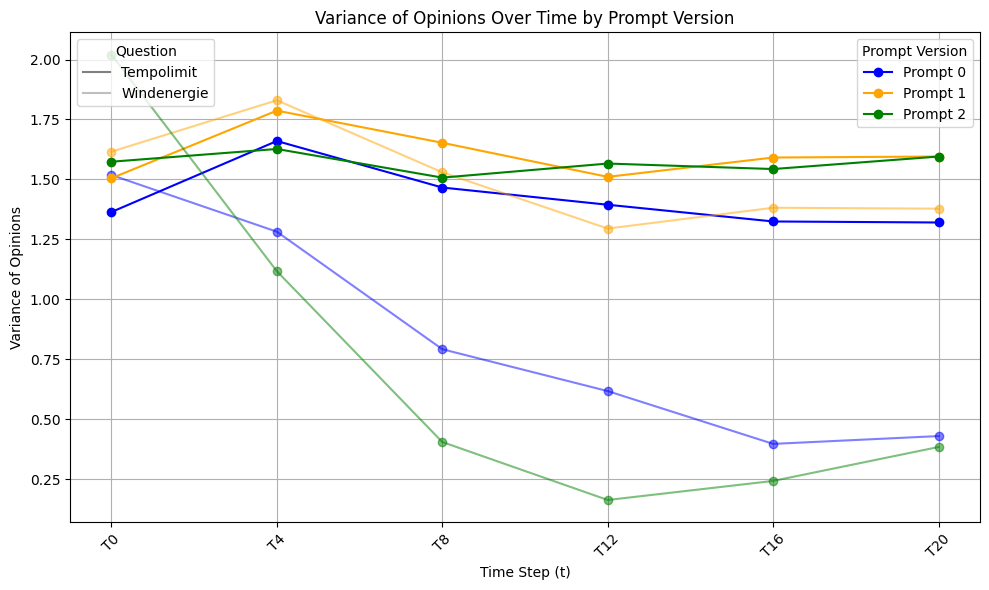

In [56]:
timesteps = [f"T{i}" for i in range(0, 21, 4)]
versions = bla["version"].unique()

variance_df = pd.DataFrame(columns=["version", "time", "variance", "question_index"])

for version in versions:
    for question_index in bla["question_index"].unique():
        for t in timesteps:
            # Filter for current version
            vals = bla[(bla["version"] == version) & (bla["question_index"] == question_index)][t]
            variance = vals.var()
            variance_df = pd.concat(
                [variance_df, pd.DataFrame({"version": [version], "time": [t], "variance": [variance], "question_index": [question_index]})],
                ignore_index=True
            )
# ...existing code...
colors = ["blue", "orange", "green"]
opaqueness = [1, 0.5, 0.8]  # Adjust opaqueness for each question

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []

for version_idx, version in enumerate(versions):
    for question_cnt, question_index in enumerate(variance_df["question_index"].unique()):
        vdf = variance_df[(variance_df["version"] == version) & (variance_df["question_index"] == question_index)]
        line, = ax.plot(
            vdf["time"], vdf["variance"], marker="o",
            color=colors[version_idx], alpha=opaqueness[question_cnt],
            label=f"Prompt {version_idx} (Q{question_index})"
        )
        if question_cnt == 0:
            prompt_handles.append(line)
        if version_idx == 0:
            # Dummy lines for question legend
            dummy, = ax.plot([], [], color="gray", alpha=opaqueness[question_cnt], label=f"Question {question_index}")
            question_handles.append(dummy)

plt.xticks(timesteps, rotation=45)
plt.xlabel("Time Step (t)")
plt.ylabel("Variance of Opinions")
plt.title("Variance of Opinions Over Time by Prompt Version")

# First legend: Prompt Version (color)
legend1 = ax.legend(prompt_handles, [f"Prompt {i}" for i in range(len(colors))], title="Prompt Version", loc="upper right")
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(question_handles, [QUESTIONS_SHORT[int(q)] for q in variance_df["question_index"].unique()], title="Question", loc="upper left")

plt.grid(True)
plt.tight_layout()
plt.show()
# ...existing code...



In [109]:
# Ensure 'version' and 'question_index' are categorical for grouping
variance_df["version"] = variance_df["version"].astype("category")
variance_df["question_index"] = variance_df["question_index"].astype("category")

# Fit a mixed effects model: variance ~ time + (1 | version) + (1 | question_index)

if variance_df["time"].dtype == "object":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(int)

variance_df["dummy_group"] = 1

vc = {"version": "0 + C(version)", "question_index": "0 + C(question_index)"}

model = smf.mixedlm(
    "variance ~ time",
    data=variance_df,
    groups="dummy_group",
    vc_formula=vc
)

result = model.fit()

print(result.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   variance
No. Observations:    36        Method:               REML    
No. Groups:          1         Scale:                0.1137  
Min. group size:     36        Log-Likelihood:       -20.1130
Max. group size:     36        Converged:            Yes     
Mean group size:     36.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.560    0.297  5.254 0.000  0.978  2.142
time               -0.028    0.008 -3.437 0.001 -0.044 -0.012
question_index Var  0.124    0.555                           
version Var         0.049    0.178                           



In [59]:
print(variance_df["time"].dtype)
if variance_df["time"].dtype != "int64":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(float)
    variance_df["time"] = variance_df["time"].astype(int)

lm = ols("variance ~ time", data=variance_df, groups=variance_df["version"]).fit()
print(lm.summary())


int64
                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     6.281
Date:                Thu, 07 Aug 2025   Prob (F-statistic):             0.0172
Time:                        12:47:52   Log-Likelihood:                -22.278
No. Observations:                  36   AIC:                             48.56
Df Residuals:                      34   BIC:                             51.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5600      0.137     11.420   

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [ ]:
for v in variance_df['version'].unique():
    for q in variance_df['question_index'].unique():
        variance_df_subset = variance_df[(variance_df['version'] == v) & (variance_df['question_index'] == q)].copy()
        if variance_df_subset["time"].dtype != "int64":
            variance_df_subset["time"] = variance_df_subset["time"].astype(int)
        
        lm = ols("variance ~ time", data=variance_df_subset).fit()
        print(f"Linear regression summary for version {v} and question {QUESTIONS_SHORT[int(q)]}:")
        print(f"time p = {lm.pvalues['time']:.4f}")
    


Linear regression summary for version 0.0 and question Tempolimit:
time p = 0.2697
Linear regression summary for version 0.0 and question Windenergie:
time p = 0.0030
Linear regression summary for version 1.0 and question Tempolimit:
time p = 0.7893
Linear regression summary for version 1.0 and question Windenergie:
time p = 0.0851
Linear regression summary for version 2.0 and question Tempolimit:
time p = 0.8376
Linear regression summary for version 2.0 and question Windenergie:
time p = 0.0462
